In [1]:
import time

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import missingno
import matplotlib.pyplot as plt
import math
import seaborn as sns

from sklearn.preprocessing import LabelEncoder


from sklearn import datasets, model_selection, tree, preprocessing, metrics, linear_model
from sklearn.linear_model import LinearRegression, LogisticRegression, Ridge, Lasso, SGDClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import LinearSVC

pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)
pd.set_option('display.width', 1000)

import warnings
warnings.filterwarnings('ignore')


import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))


/kaggle/input/titanic/train.csv
/kaggle/input/titanic/test.csv
/kaggle/input/titanic/gender_submission.csv


In [2]:
TRAIN_PATH = '../input/titanic/train.csv'
TEST_PATH = '../input/titanic/test.csv'

**Target:** 
For each passenger in the test set to predict whether or not they survived the sinking of the Titanic.

**Prediction problem:**
Classification

**Data Dictionary:**

survival -> Survival ->	0 = No, 1 = Yes
pclass -> Ticket class -> 1 = 1st, 2 = 2nd, 3 = 3rd
sex -> Sex	
Age -> Age in years	
sibsp -> # of siblings / spouses aboard the Titanic	
parch ->	# of parents / children aboard the Titanic	
ticket -> Ticket number	
fare ->	Passenger fare	
cabin -> Cabin number	
embarked ->	Port of Embarkation	C = Cherbourg, Q = Queenstown, S = Southampton

**Variable Notes:**

pclass: A proxy for socio-economic status (SES)
1st = Upper
2nd = Middle
3rd = Lower

age: Age is fractional if less than 1. If the age is estimated, is it in the form of xx.5

sibsp: The dataset defines family relations in this way...
Sibling = brother, sister, stepbrother, stepsister
Spouse = husband, wife (mistresses and fiancés were ignored)

parch: The dataset defines family relations in this way...
Parent = mother, father
Child = daughter, son, stepdaughter, stepson
Some children travelled only with a nanny, therefore parch=0 for them.

# Load of data sets

In [3]:
#Load of data sets
def read_file(path = '', use_cols = None):
    if use_cols is not None: 
        df = pd.read_csv(path, columns = use_cols)
    else:
        df = pd.read_csv(path)
    print('Shape of dataframe: {}'.format(df.shape))
    
    return df

train_df = read_file(TRAIN_PATH)
test_df = read_file(TEST_PATH)

Shape of dataframe: (891, 12)
Shape of dataframe: (418, 11)


# Data Exploration
1. Univariate
2. Bi-variate

In [4]:
train_df.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [5]:
test_df.head()

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,892,3,"Kelly, Mr. James",male,34.5,0,0,330911,7.8292,NaN,Q
1,893,3,"Wilkes, Mrs. James (Ellen Needs)",female,47.0,1,0,363272,7.0000,NaN,S
2,894,2,"Myles, Mr. Thomas Francis",male,62.0,0,0,240276,9.6875,NaN,Q
3,895,3,"Wirz, Mr. Albert",male,27.0,0,0,315154,8.6625,NaN,S
4,896,3,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",female,22.0,1,1,3101298,12.2875,NaN,S


In [6]:
def info_summary(dataset):
    output = []
    df_name = [x for x in globals() if globals()[x] is dataset][0]
    for col in dataset.columns:
        d_type = dataset[col].dtype
        unique = dataset[col].nunique()
        na = dataset[col].isna().sum()
        non_missing = len(dataset[col]) - na
        missing_percentage = (na / len(dataset[col])) * 100
        output.append([col, d_type, unique, na, non_missing, missing_percentage])
    df_info = pd.DataFrame(output, columns = ['column', 'data_type', 'unique values', 'missing values', 'non_missing values', 'missing_%'])
    print('{name} SUMMARY \n\n {df}\n\n Describe the numerical features:\n\n{describe} \n\n Describe the categorical features:\n\n {cat_describe}\n\n'.format(name = df_name.upper(), df = df_info, describe = dataset.describe(), cat_describe = dataset.describe(include=['O'])))
    
info_summary(train_df)
info_summary(test_df)

TRAIN_DF SUMMARY 

          column data_type  unique values  missing values  non_missing values  missing_%
0   PassengerId     int64            891               0                 891   0.000000
1      Survived     int64              2               0                 891   0.000000
2        Pclass     int64              3               0                 891   0.000000
3          Name    object            891               0                 891   0.000000
4           Sex    object              2               0                 891   0.000000
5           Age   float64             88             177                 714  19.865320
6         SibSp     int64              7               0                 891   0.000000
7         Parch     int64              7               0                 891   0.000000
8        Ticket    object            681               0                 891   0.000000
9          Fare   float64            248               0                 891   0.000000
10        Ca

<AxesSubplot:>

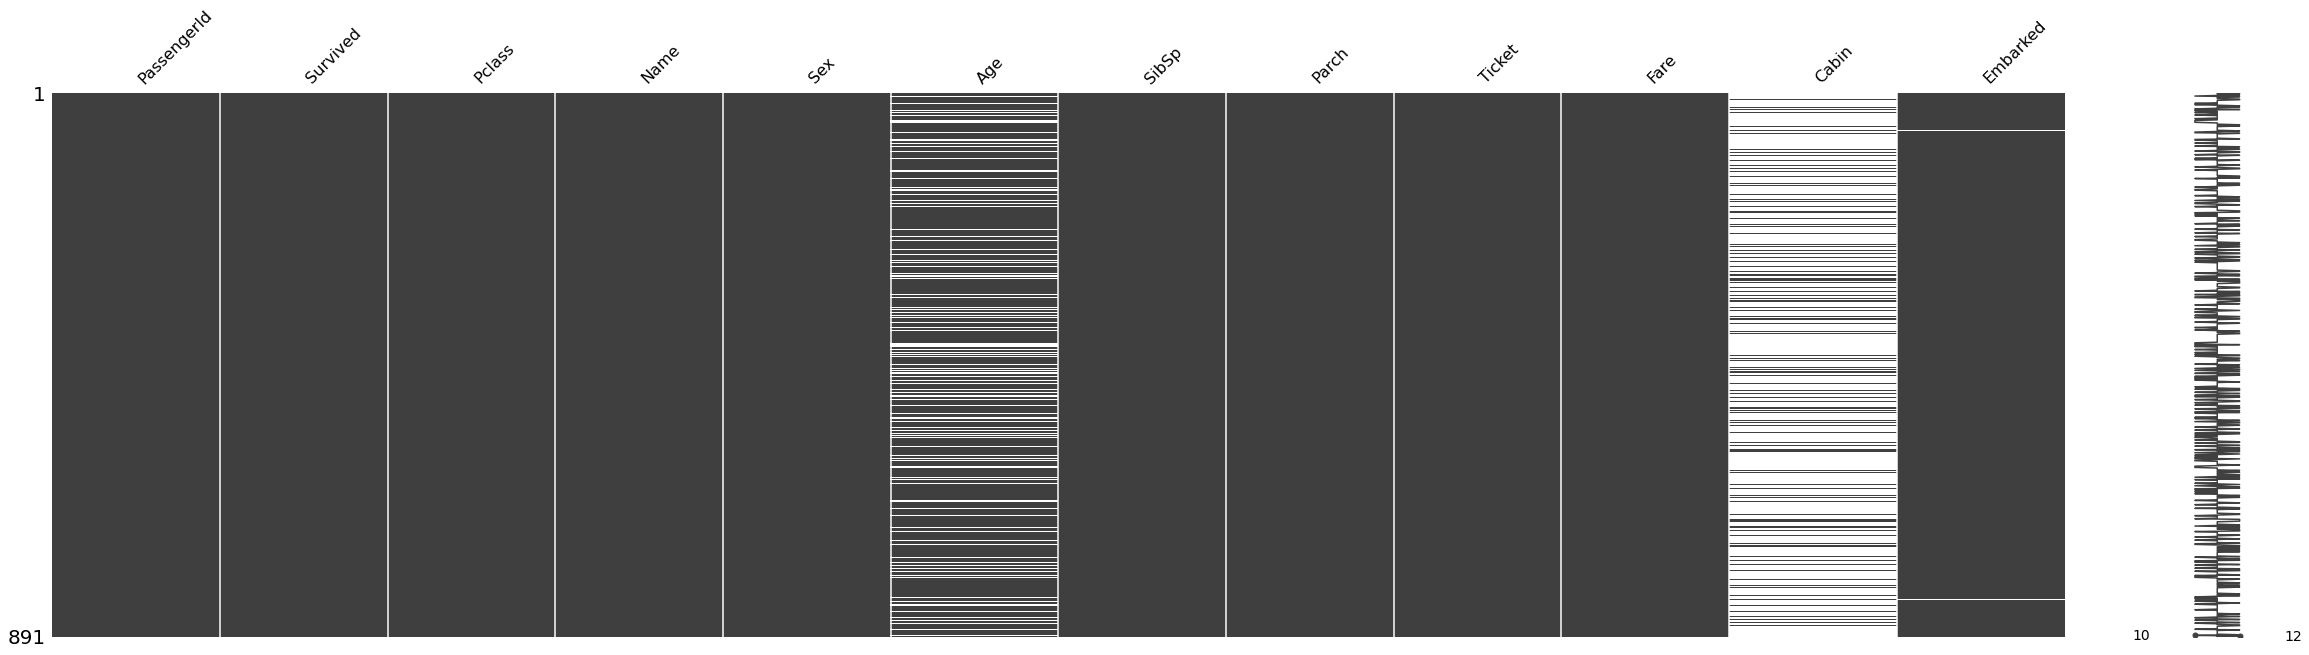

In [7]:
#Visualization of missing values
missingno.matrix(train_df, figsize = (40, 10))

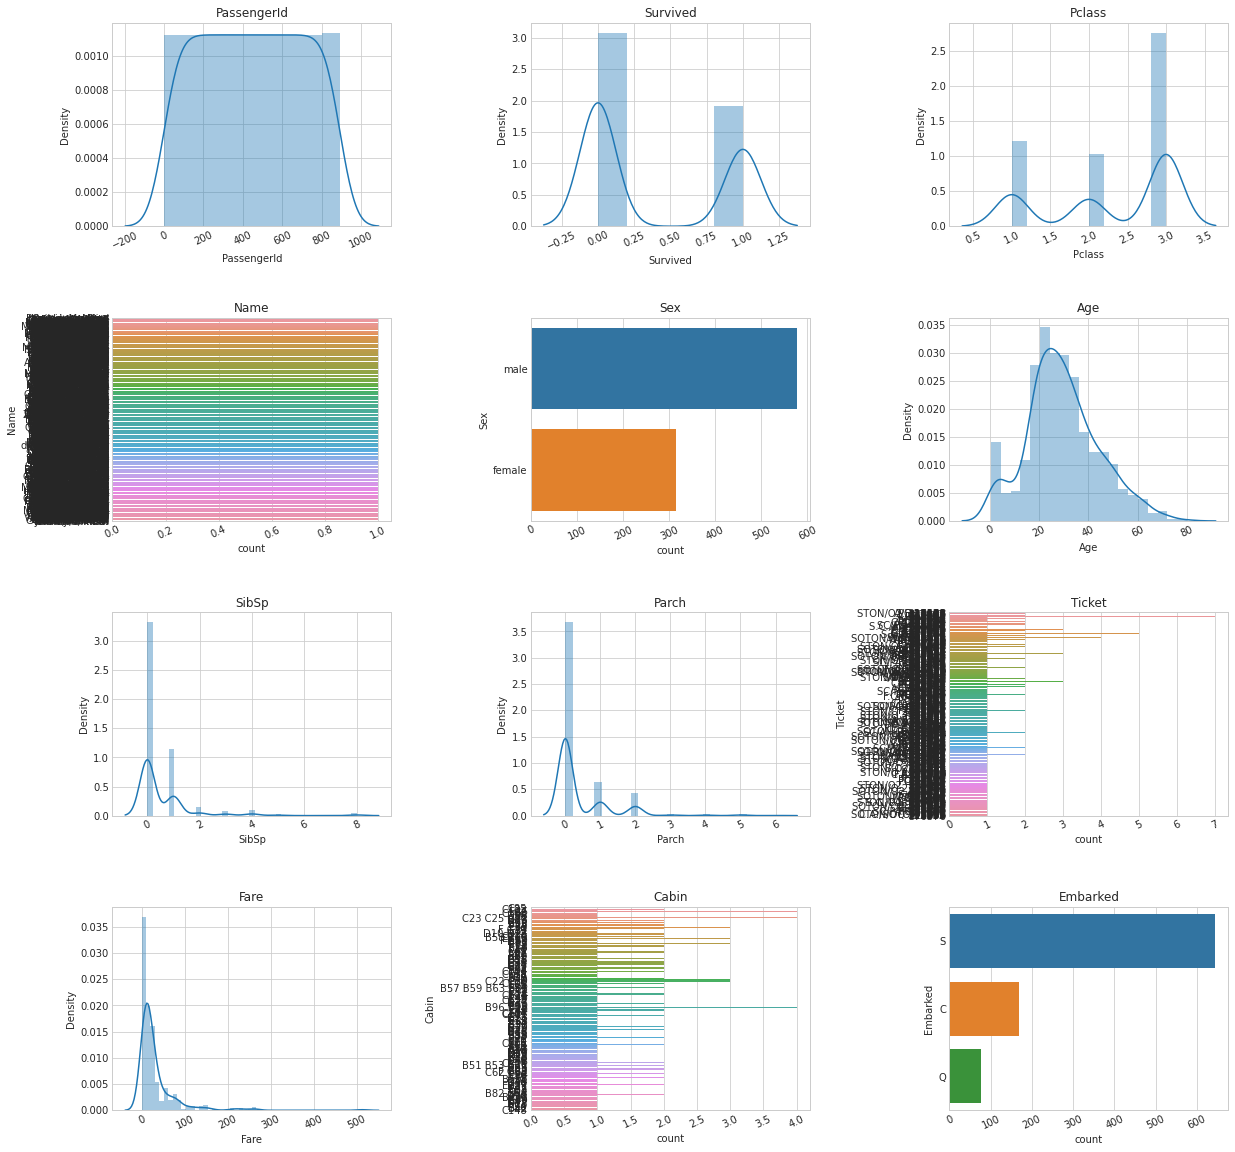

In [8]:
def plot_distribution(data, cols = 5, height = 20, width = 20, hspace=0.45, wspace=0.5):
    plt.style.use('seaborn-whitegrid')
    fig = plt.figure(figsize=(width,height))
    fig.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=wspace, hspace=hspace)
    rows = math.ceil(float(data.shape[1]) / cols)
    for i, column in enumerate(data.columns):
        ax = fig.add_subplot(rows, cols, i + 1)
        ax.set_title(column)
        if data.dtypes[column] == np.object:
            g = sns.countplot(y=column, data=data)
            substrings = [s.get_text()[:15] for s in g.get_yticklabels()]
            g.set(yticklabels=substrings)
            plt.xticks(rotation=25)
        else:
            g = sns.distplot(data[column])
            plt.xticks(rotation=25)
    
plot_distribution(train_df, cols=3, height=20, width=20, hspace=0.45, wspace=0.5)

# FEATURE ENGINEERING
>*Feature engineering is the process of transforming raw data into features that better represent the underlying problem to the predictive models, resulting in improved model accuracy on unseen data. Source: [https://machinelearningmastery.com/discover-feature-engineering-how-to-engineer-features-and-how-to-get-good-at-it/](http://)*

* cleaning - missing values, outliers, discrepancies...
* engineering - Decomposition of a Date-Time (extraction of hour,weekday,..) and Categorical Attributes, Reframing of Numerical Quantities(i.e. from minus to hours), Discretization of Continuous variables(->bins), Feature crossing(creation of new variables via combination of the current ones)
* imputation - imputation of missing values - mean, mode, regression, ...

In [9]:
# creation of empty dataframes
dataset_bin = pd.DataFrame()
dataset_con = pd.DataFrame()    

In [10]:
# plotting function
def plot_feature(feature, data):
    plt.style.use('seaborn-whitegrid')
    plt.figure(figsize=(20,3)) 
    sns.countplot(y=feature, data=data);
    

Target Feature: Survived
* Whether the particular passenger survived or not
* 0 - dindt survive; 1 - survived

In [11]:
train_df['Survived'].value_counts()

0    549
1    342
Name: Survived, dtype: int64

In [12]:
dataset_bin['Survived'] = dataset_con['Survived'] = train_df['Survived']

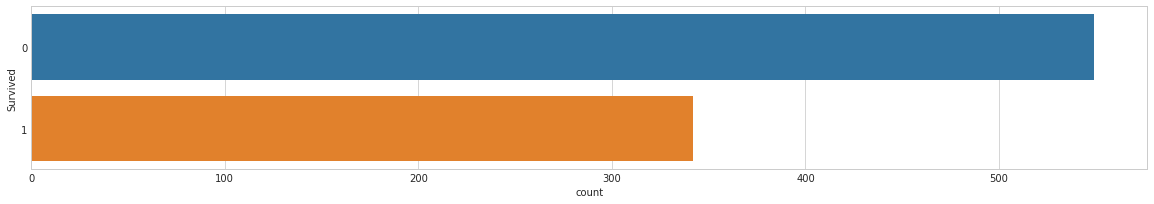

In [13]:
plot_feature('Survived', train_df)

Feature: Pclass
* no missing values
* no outliers
* nominal variable

In [14]:
train_df['Pclass'].value_counts()

3    491
1    216
2    184
Name: Pclass, dtype: int64

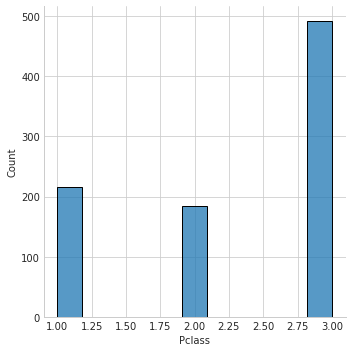

In [15]:
sns.displot(train_df['Pclass'])

In [16]:
dataset_bin['Pclass'] = dataset_con['Pclass'] = train_df['Pclass']

Feature: **Name**

TO-DO
Feature crossing : 
extract title and create bins 
plus take only last names

In [17]:
train_df['Name'].value_counts()[:10]

Braund, Mr. Owen Harris                            1
Boulos, Mr. Hanna                                  1
Frolicher-Stehli, Mr. Maxmillian                   1
Gilinski, Mr. Eliezer                              1
Murdlin, Mr. Joseph                                1
Rintamaki, Mr. Matti                               1
Stephenson, Mrs. Walter Bertram (Martha Eustis)    1
Elsbury, Mr. William James                         1
Bourke, Miss. Mary                                 1
Chapman, Mr. John Henry                            1
Name: Name, dtype: int64

Feature: **Sex**
* no missing values
* binary variable

In [18]:
train_df['Sex'].value_counts()

male      577
female    314
Name: Sex, dtype: int64

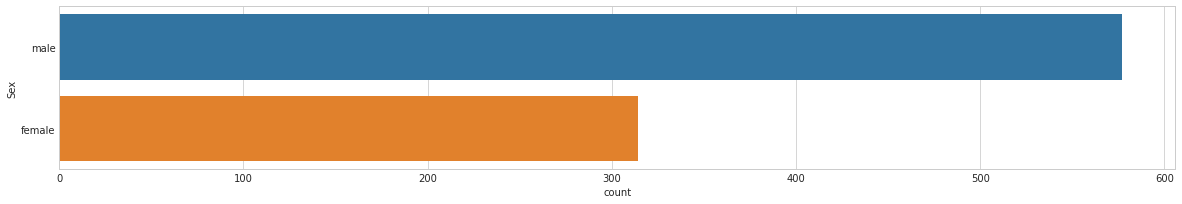

In [19]:
plot_feature('Sex', train_df)

In [20]:
dataset_bin['Sex'] = dataset_con['Sex'] = train_df['Sex']

In [21]:
dataset_bin['Sex'] = np.where(dataset_bin['Sex'] == 'female', 1, 0)
dataset_con['Sex'] = dataset_con['Sex']

In [22]:
dataset_bin.head()

,Survived,Pclass,Sex
0,0,3,0
1,1,1,1
2,1,3,1
3,1,1,1
4,0,3,0


In [23]:
dataset_con.head()

,Survived,Pclass,Sex
0,0,3,male
1,1,1,female
2,1,3,female
3,1,1,female
4,0,3,male


Feature: **Age**
* many null values
TODO - 
Imputation - calculate age according to the title -> predict age based on title
* to be discretionized

In [24]:
#dataset_bin['Age'] = pd.cut(train_df['Age'], 10)
#dataset_con['Age'] = train_df['Age']

show graph of age bucket distributions

Feature: **SibSp**
* no missing values
* TO-DO
 Feature crossing : create new feature - Sibling: Yes/No

In [25]:
train_df['SibSp'].value_counts()

0    608
1    209
2     28
4     18
3     16
8      7
5      5
Name: SibSp, dtype: int64

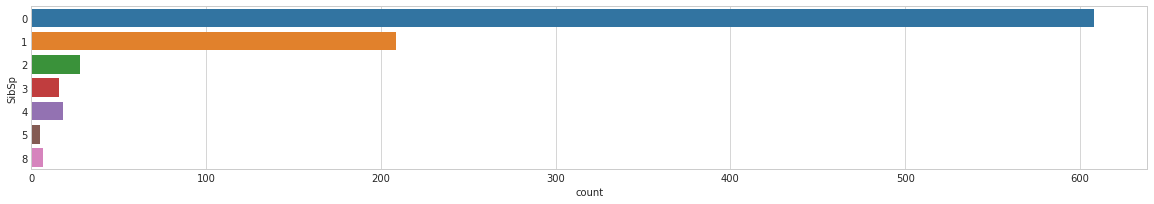

In [26]:
plot_feature('SibSp', train_df)

In [27]:
dataset_bin['SibSp'] = dataset_con['SibSp'] = train_df['SibSp']

Feature: **Parch**
* no missing values

In [28]:
train_df['Parch'].value_counts()

0    678
1    118
2     80
5      5
3      5
4      4
6      1
Name: Parch, dtype: int64

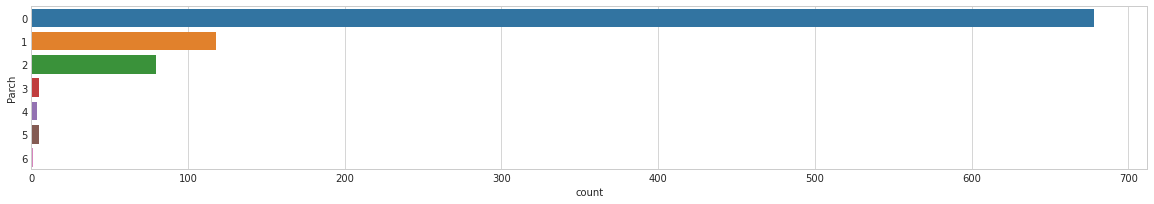

In [29]:
plot_feature('Parch', train_df)

In [30]:
dataset_bin['Parch'] = dataset_con['Parch'] =  train_df['Parch']

TODO - new feature - is alone - no sibs no parch


Feature: **Ticket**
* no null values
* not going to include it now as I dont see any pattern in ticket codes
* to be discretionized

In [31]:
train_df['Ticket'].value_counts()[:10]

347082          7
CA. 2343        7
1601            7
3101295         6
CA 2144         6
347088          6
S.O.C. 14879    5
382652          5
LINE            4
PC 17757        4
Name: Ticket, dtype: int64

Feature: **Fare**
* no missing values
* to 

In [32]:
train_df['Fare'].value_counts()

8.0500      43
13.0000     42
7.8958      38
7.7500      34
26.0000     31
10.5000     24
7.9250      18
7.7750      16
7.2292      15
0.0000      15
26.5500     15
7.8542      13
8.6625      13
7.2500      13
7.2250      12
9.5000       9
16.1000      9
24.1500      8
15.5000      8
14.4542      7
69.5500      7
52.0000      7
7.0500       7
56.4958      7
14.5000      7
31.2750      7
39.6875      6
7.7958       6
27.9000      6
30.0000      6
46.9000      6
26.2500      6
21.0000      6
27.7208      5
29.1250      5
15.2458      5
73.5000      5
30.5000      5
53.1000      5
39.0000      4
90.0000      4
15.8500      4
13.5000      4
7.5500       4
23.0000      4
12.4750      4
25.4667      4
7.1250       4
7.6500       4
21.0750      4
7.7333       4
11.5000      4
34.3750      4
7.8792       4
19.2583      4
227.5250     4
27.7500      4
263.0000     4
31.3875      4
79.2000      4
151.5500     4
35.5000      4
120.0000     4
110.8833     4
7.4958       3
83.1583      3
211.3375  

In [33]:
dataset_bin['Fare'] = pd.cut(train_df['Fare'], bins = 5)
dataset_con['Fare'] = train_df['Fare']

In [34]:
dataset_bin.head(5)

,Survived,Pclass,Sex,SibSp,Parch,Fare
0,0,3,0,1,0,"(-0.512, 102.466]"
1,1,1,1,1,0,"(-0.512, 102.466]"
2,1,3,1,0,0,"(-0.512, 102.466]"
3,1,1,1,1,0,"(-0.512, 102.466]"
4,0,3,0,0,0,"(-0.512, 102.466]"


In [35]:
dataset_con.head(5)

,Survived,Pclass,Sex,SibSp,Parch,Fare
0,0,3,male,1,0,7.2500
1,1,1,female,1,0,71.2833
2,1,3,female,0,0,7.9250
3,1,1,female,1,0,53.1000
4,0,3,male,0,0,8.0500


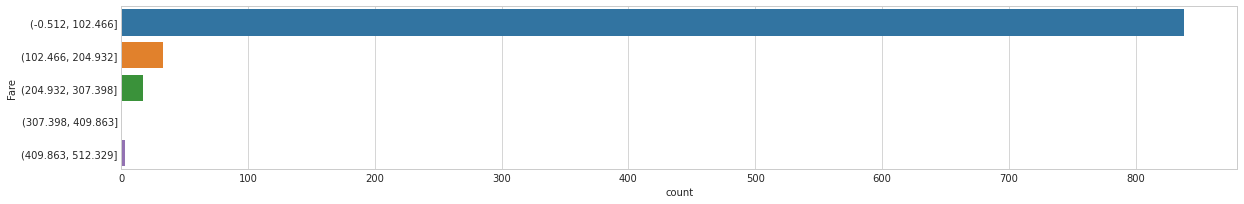

In [36]:
plot_feature('Fare', dataset_bin)

Feature: **Cabin**
* 687 missing values
* too many missing values -> not to be included now
* TO-DO cabins can be discretionized and maybe inputed from ticket/embarked/class

In [37]:
train_df['Cabin'].value_counts()

B96 B98            4
G6                 4
C23 C25 C27        4
C22 C26            3
F33                3
F2                 3
E101               3
D                  3
C78                2
C93                2
E8                 2
D36                2
B77                2
C123               2
E121               2
E44                2
D35                2
C125               2
E67                2
B35                2
B18                2
E24                2
B49                2
C65                2
B20                2
B5                 2
B57 B59 B63 B66    2
C126               2
B51 B53 B55        2
F4                 2
C124               2
F G73              2
B58 B60            2
C52                2
D33                2
C68                2
D20                2
D26                2
B28                2
C83                2
E25                2
D17                2
B22                2
C92                2
C2                 2
E33                2
C70                1
E58          

Feature: **Embarked**
* two missing values - to be deleted for now

In [38]:
train_df['Embarked'].value_counts()

S    644
C    168
Q     77
Name: Embarked, dtype: int64

In [39]:
train_df['Embarked'].isna().sum()

2

In [40]:
train_df[train_df['Embarked'].isna()]

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
61,62,1,1,"Icard, Miss. Amelie",female,38.0,0,0,113572,80.0,B28,NaN
829,830,1,1,"Stone, Mrs. George Nelson (Martha Evelyn)",female,62.0,0,0,113572,80.0,B28,NaN


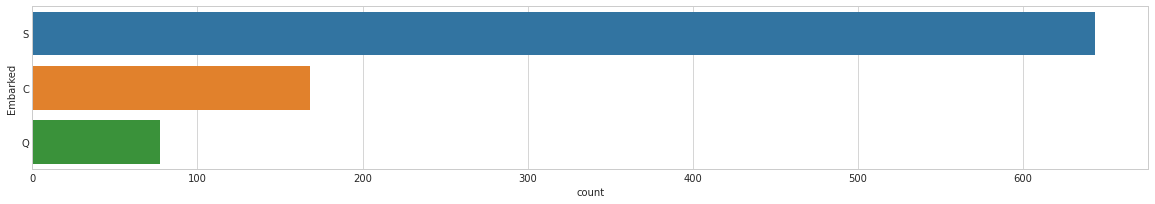

In [41]:
plot_feature('Embarked', train_df)

In [42]:
dataset_bin['Embarked'] = dataset_con['Embarked'] = train_df['Embarked']

In [43]:
dataset_bin= dataset_bin.dropna(subset=['Embarked'])
dataset_con= dataset_con.dropna(subset=['Embarked'])

In [44]:
dataset_con.head()

,Survived,Pclass,Sex,SibSp,Parch,Fare,Embarked
0,0,3,male,1,0,7.2500,S
1,1,1,female,1,0,71.2833,C
2,1,3,female,0,0,7.9250,S
3,1,1,female,1,0,53.1000,S
4,0,3,male,0,0,8.0500,S


**Bi_variate Feature Analysis**

TODO create charts

In [45]:
sns.set_style('darkgrid')
sns.set(font_scale=1.3)

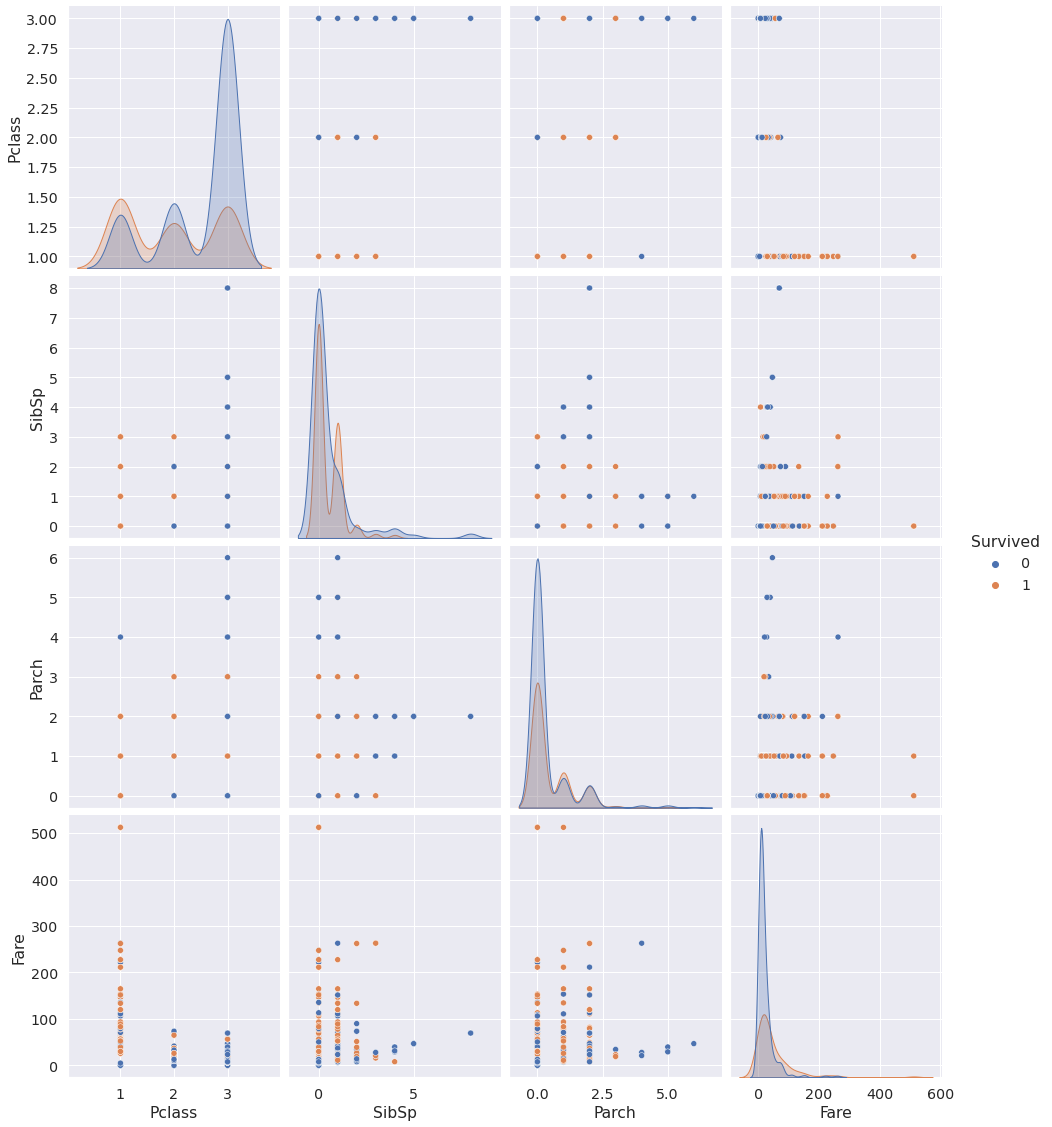

In [46]:
sns.pairplot(dataset_con[['Survived','Pclass', 'Sex', 'SibSp', 'Parch', 'Fare', 'Embarked']],
            hue='Survived',
            aspect=.85,
            diag_kind='kde',
            size=4);

<AxesSubplot:>

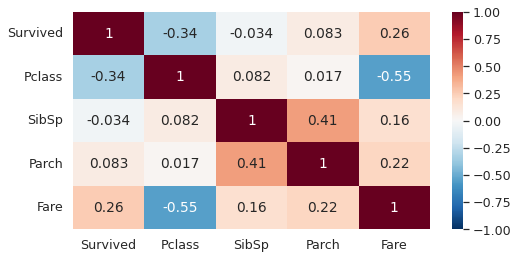

In [47]:
sns.set(font_scale=1.15)
plt.figure(figsize=(8,4))

sns.heatmap(
    dataset_con.corr(),
    cmap='RdBu_r',
    annot=True,
    vmin=-1, vmax=1)

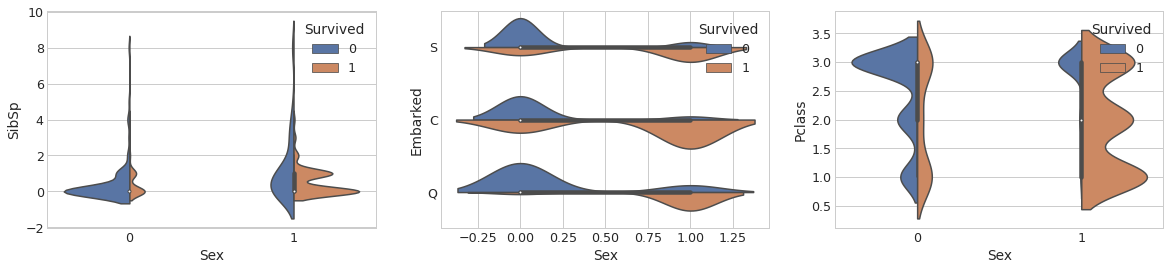

In [48]:
plt.style.use('seaborn-whitegrid')
fig = plt.figure(figsize=(20,4)) 
plt.subplot(1, 3, 1)
sns.violinplot(x='Sex', y='SibSp', hue='Survived', data=dataset_bin, split=True, scale='count');

plt.subplot(1, 3, 2)
sns.violinplot(x='Sex', y='Embarked', hue='Survived', data=dataset_bin, split=True, scale='count');

plt.subplot(1, 3, 3)
sns.violinplot(x='Sex', y='Pclass', hue='Survived', data=dataset_bin, split=True, scale='count');

# Feature Encoding
* Machine learning algorithms can only work with numerical values so we have to transform all categorical features into numerical ones.
* Methods:
            1. One-Hot Encoding - creates new columns representing particular category of the categorical feature
            2. Label Encoding - encodes categories with numbers
            3. Ordinal Encoding
            4. Target Encoding
            5. Frequency Encoding
            6. Mean Encoding


In [49]:
dataset_bin.head()

,Survived,Pclass,Sex,SibSp,Parch,Fare,Embarked
0,0,3,0,1,0,"(-0.512, 102.466]",S
1,1,1,1,1,0,"(-0.512, 102.466]",C
2,1,3,1,0,0,"(-0.512, 102.466]",S
3,1,1,1,1,0,"(-0.512, 102.466]",S
4,0,3,0,0,0,"(-0.512, 102.466]",S


In [50]:
dataset_con.head()

,Survived,Pclass,Sex,SibSp,Parch,Fare,Embarked
0,0,3,male,1,0,7.2500,S
1,1,1,female,1,0,71.2833,C
2,1,3,female,0,0,7.9250,S
3,1,1,female,1,0,53.1000,S
4,0,3,male,0,0,8.0500,S


In [51]:
#One-Hot encoding applied on the dataset with binned variable
one_hot_cols = dataset_bin.columns.tolist()
one_hot_cols.remove('Survived')
dataset_bin_enc = pd.get_dummies(dataset_bin, columns = one_hot_cols)

dataset_bin_enc.head()

,Survived,Pclass_1,Pclass_2,Pclass_3,Sex_0,Sex_1,SibSp_0,SibSp_1,SibSp_2,SibSp_3,SibSp_4,SibSp_5,SibSp_8,Parch_0,Parch_1,Parch_2,Parch_3,Parch_4,Parch_5,Parch_6,"Fare_(-0.512, 102.466]","Fare_(102.466, 204.932]","Fare_(204.932, 307.398]","Fare_(307.398, 409.863]","Fare_(409.863, 512.329]",Embarked_C,Embarked_Q,Embarked_S
0,0,0,0,1,1,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,1
1,1,1,0,0,0,1,0,1,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,1,0,0
2,1,0,0,1,0,1,1,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,1
3,1,1,0,0,0,1,0,1,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,1
4,0,0,0,1,1,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,1


In [52]:
# Label Encoding applied to continuous values
dataset_con_enc = dataset_con.apply(LabelEncoder().fit_transform)

dataset_con_enc.head()

,Survived,Pclass,Sex,SibSp,Parch,Fare,Embarked
0,0,2,1,1,0,18,2
1,1,0,0,1,0,207,0
2,1,2,0,0,0,41,2
3,1,0,0,1,0,189,2
4,0,2,1,0,0,43,2


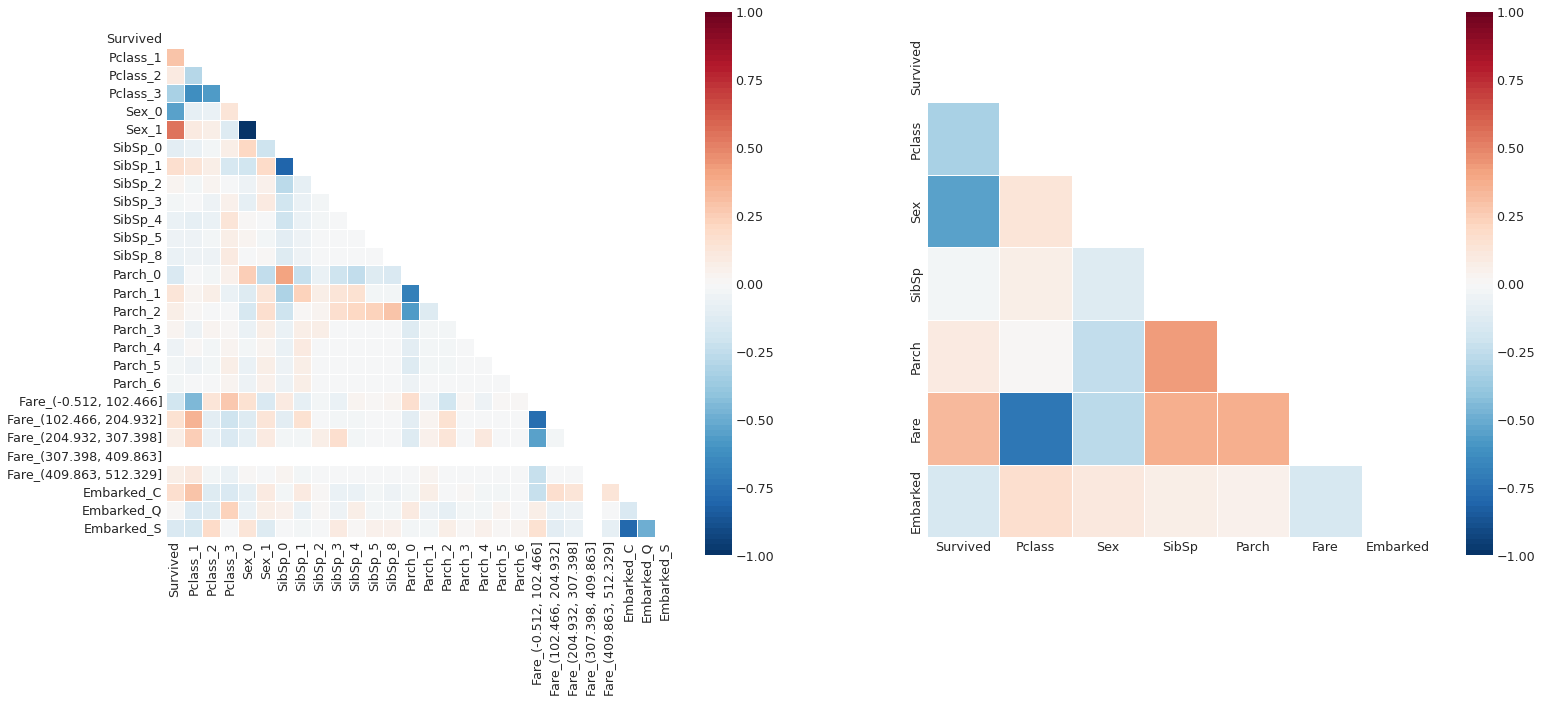

In [53]:
# a correlation plot
plt.style.use('seaborn-whitegrid')
fig = plt.figure(figsize=(25,10)) 

plt.subplot(1, 2, 1)
mask = np.zeros_like(dataset_bin_enc.corr(), dtype=np.bool)
mask[np.triu_indices_from(mask)] = True
sns.heatmap(dataset_bin_enc.corr(), 
            vmin=-1, vmax=1, 
            square=True, 
            cmap=sns.color_palette("RdBu_r", 100), 
            mask=mask, 
            linewidths=.5);

plt.subplot(1, 2, 2)
mask = np.zeros_like(dataset_con_enc.corr(), dtype=np.bool)
mask[np.triu_indices_from(mask)] = True
sns.heatmap(dataset_con_enc.corr(), 
            vmin=-1, vmax=1, 
            square=True, 
            cmap=sns.color_palette("RdBu_r", 100), 
            mask=mask, 
            linewidths=.5);

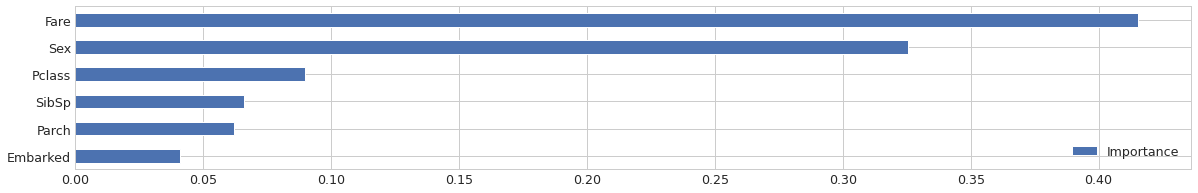

In [54]:
# Using Random Forest to gain an insight on Feature Importance
clf = RandomForestClassifier()
clf.fit(dataset_con_enc.drop('Survived', axis=1), dataset_con_enc['Survived'])

plt.style.use('seaborn-whitegrid')
importance = clf.feature_importances_
importance = pd.DataFrame(importance, index=dataset_con_enc.drop('Survived', axis=1).columns, columns=["Importance"])
importance.sort_values(by='Importance', ascending=True).plot(kind='barh', figsize=(20,len(importance)/2));


In [55]:
importance.sort_values(by='Importance', ascending=False)

,Importance
Fare,0.415268
Sex,0.325654
Pclass,0.089954
SibSp,0.066010
Parch,0.062064
Embarked,0.041052


# Machine Learning
* split data - data already split
* train model
* tune model
* predict

In [56]:
dataset = dataset_con_enc

In [57]:
dataset.head()

,Survived,Pclass,Sex,SibSp,Parch,Fare,Embarked
0,0,2,1,1,0,18,2
1,1,0,0,1,0,207,0
2,1,2,0,0,0,41,2
3,1,0,0,1,0,189,2
4,0,2,1,0,0,43,2


In [58]:
X_train = dataset.drop(['Survived'], axis=1)
train_columns = X_train.columns
y_train = dataset['Survived'].astype('int64')

In [59]:
X_train.head()

,Pclass,Sex,SibSp,Parch,Fare,Embarked
0,2,1,1,0,18,2
1,0,0,1,0,207,0
2,2,0,0,0,41,2
3,0,0,1,0,189,2
4,2,1,0,0,43,2


In [60]:
y_train.head()

0    0
1    1
2    1
3    1
4    0
Name: Survived, dtype: int64

In [61]:
X_train.shape

(889, 6)

In [62]:
y_train.shape

(889,)

In [63]:
def fit_ml_algo(algo, X_train, y_train, cv):
    model = algo.fit(X_train, y_train)
    acc = model.score(X_train, y_train)
    
    train_pred = model_selection.cross_val_predict(
            algo,
            X_train,
            y_train,
            cv = cv,
            n_jobs = -1)
    acc_cv = metrics.accuracy_score(y_train, train_pred)
    
    return train_pred, acc, acc_cv

In [64]:
# Logistic regression
start_time = time.time()
train_pred_log, acc_log, acc_cv_log = fit_ml_algo(LogisticRegression(),
                                                 X_train,
                                                 y_train,
                                                 10)
log_time = time.time() - start_time

In [65]:
# KNN
start_time = time.time()
train_pred_knn, acc_knn, acc_cv_knn = fit_ml_algo(KNeighborsClassifier(),
                                                 X_train,
                                                 y_train,
                                                 10)
knn_time = time.time() - start_time

In [66]:
# Stochastic Gradient Descent
start_time = time.time()
train_pred_sgd, acc_sgd, acc_cv_sgd = fit_ml_algo(SGDClassifier(),
                                                 X_train,
                                                 y_train,
                                                 10)
sgd_time = time.time() - start_time

In [67]:
# Decision Tree Classifier
start_time = time.time()
train_pred_dt, acc_dt, acc_cv_dt = fit_ml_algo(DecisionTreeClassifier(),
                                                 X_train,
                                                 y_train,
                                                 10)
dt_time = time.time() - start_time

In [68]:
# Gaussian Naive Bayes
start_time = time.time()
train_pred_gauss, acc_gauss, acc_cv_gauss = fit_ml_algo(GaussianNB(),
                                                       X_train,
                                                       y_train,
                                                       10)

gauss_time = time.time() - start_time

In [69]:
# Support Vector Machines
start_time = time.time()
train_pred_gauss, acc_svc, acc_cv_svc = fit_ml_algo(LinearSVC(),
                                                       X_train,
                                                       y_train,
                                                       10)

svc_time = time.time() - start_time

In [70]:
# Gradient Boosting Trees
start_time = time.time()
train_pred_gbt, acc_gbt, acc_cv_gbt = fit_ml_algo(GradientBoostingClassifier(), 
                                                                       X_train, 
                                                                       y_train,
                                                                       10)
gbt_time = (time.time() - start_time)

In [71]:
models = pd.DataFrame({
    'Model' : ['Logistic Regression', 'KNN', 'Stochastic Gradient Descent', 
               'Decision Tree','Gaussian Naive Bayes','Support Vector Machines',
              'Gradient Boosting Trees'],
    'Score' : [
        acc_log,
        acc_knn,
        acc_sgd,
        acc_dt,
        acc_gauss,
        acc_svc,
        acc_gbt
    ],
    'CV Score' : [
        acc_cv_log,
        acc_cv_knn,
        acc_cv_sgd,
        acc_cv_dt,
        acc_cv_gauss,
        acc_cv_svc,
        acc_gbt
    ],
    'Time' : [
        log_time,
        knn_time,
        sgd_time,
        dt_time,
        gauss_time,
        svc_time,
        acc_gbt
    ]})
models.sort_values(by='CV Score', ascending=False)

,Model,Score,CV Score,Time
6,Gradient Boosting Trees,0.863892,0.863892,0.863892
3,Decision Tree,0.924634,0.797525,0.067671
0,Logistic Regression,0.794151,0.781777,1.917428
4,Gaussian Naive Bayes,0.767154,0.763780,0.071395
1,KNN,0.805399,0.740157,0.139779
5,Support Vector Machines,0.701912,0.725534,0.219921
2,Stochastic Gradient Descent,0.591676,0.596175,0.073782


In [72]:
# Gradient Boosting Trees
start_time = time.time()
gbt = GradientBoostingClassifier()
gbt.fit(X_train, y_train)

GradientBoostingClassifier()

# Submission

In [73]:
X_train.head()


,Pclass,Sex,SibSp,Parch,Fare,Embarked
0,2,1,1,0,18,2
1,0,0,1,0,207,0
2,2,0,0,0,41,2
3,0,0,1,0,189,2
4,2,1,0,0,43,2


In [74]:
test_df.head()

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,892,3,"Kelly, Mr. James",male,34.5,0,0,330911,7.8292,NaN,Q
1,893,3,"Wilkes, Mrs. James (Ellen Needs)",female,47.0,1,0,363272,7.0000,NaN,S
2,894,2,"Myles, Mr. Thomas Francis",male,62.0,0,0,240276,9.6875,NaN,Q
3,895,3,"Wirz, Mr. Albert",male,27.0,0,0,315154,8.6625,NaN,S
4,896,3,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",female,22.0,1,1,3101298,12.2875,NaN,S


In [75]:
train_columns = X_train.columns

In [76]:
X_test = test_df[train_columns]

In [77]:
X_test = X_test.apply(LabelEncoder().fit_transform)

In [78]:
X_test.head()

,Pclass,Sex,SibSp,Parch,Fare,Embarked
0,2,1,0,0,24,1
1,2,0,1,0,5,2
2,1,1,0,0,41,1
3,2,1,0,0,34,2
4,2,0,1,1,46,2


In [79]:
predictions = gbt.predict(X_test)

to do : hyperparametrization


In [80]:
predictions[:20]

array([0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 1, 1, 0, 0, 0, 0])

In [81]:
submission = pd.DataFrame()
submission['PassengerId'] = test_df['PassengerId']
submission['Survived'] = predictions
submission.head()

,PassengerId,Survived
0,892,0
1,893,0
2,894,0
3,895,0
4,896,0


In [82]:
submission['Survived'] = submission['Survived'].astype(int)

In [83]:
submission.head()

,PassengerId,Survived
0,892,0
1,893,0
2,894,0
3,895,0
4,896,0


In [84]:
submission.to_csv('./gbt_submission.csv', index=False)